## Functions to put all Feather River data for each WSN into tables
Ignoring nodes 7 and 11 for GRZL, 3 for KTL since they have some missing sensor types

In [6]:
import numpy as np
from ModelTest import *
import pandas as pd
import matplotlib.pyplot as plt
from Utilities import obsFrac, getMidnightNoonIdx
from SSMTools import *
import datetime
from os import listdir
from os.path import isfile, join

In [3]:
colors = 2*[c["color"] for c in plt.rcParams["axes.prop_cycle"]]

In [146]:
base_data_path = "../raw_data/feather_data/"
output_path = "../raw_data/feather_data/"

# Info on what's available
feather_wsns = ["KTL", "GRZL"]
feather_sensortypes = ["snowdepth", "snowdepth_stdev", "rel_humidity", "air_temp", "solar_rad"]

### Merge each site's data into one big dataframe and save it

In [212]:
for wsn in feather_wsns: # loop over WSNs
    # Directory containing WSN's data files
    wsn_data_path = base_data_path + wsn + "/"

    # Get list of sensor MAC addresses for which we have all data
    mac_addresses = [f[0:-4] for f in listdir(wsn_data_path + feather_sensortypes[0]) if isfile(join(wsn_data_path + feather_sensortypes[0], f))]
    # Convert each MAC address to a node label for simplicity
    node_labels = {i: mac_addresses[i] for i in range(len(mac_addresses))}

    df_wsn = pd.DataFrame(columns=["time"])

    for i in node_labels: # for each node
        for st in feather_sensortypes: # get data for the sensor
            sensor_file_name = wsn_data_path + st + "/" + node_labels[i] + ".csv"
            #print sensor_file_name

            if isfile(sensor_file_name):
                # Load the raw data
                df_sensor = pd.read_csv(sensor_file_name, delimiter=";")

                # Change column names
                df_sensor.columns = ["time", st + "_%i" % i]

                # Convert first column to time datatype
                df_sensor["time"] = pd.to_datetime(df_sensor["time"])
                
                # Convert solar radiation to W / m^2
                if st == "solar_rad":
                    df_sensor["solar_rad_%i" % i] = df_sensor["solar_rad_%i" % i] / 14.91

                # Round times that are off by a minute or second
                for j, t in df_sensor["time"].iteritems():
                    rounded = False

                    # Round seconds
                    if 30 < t.second <= 59:
                        t = t.replace(minute=t.minute+1).replace(second=0)
                        rounded = True
                    elif 1 <= t.second <= 30:
                        t = t.replace(second=0)
                        rounded = True
                    # Round to nearest 5 minutes
                    if t.minute % 5 != 0:
                        t = t.replace(minute=int(5*round(float(t.minute)/5)) % 60)
                        rounded = True

                    # Reset timestamp if it was changed
                    if rounded:
                        df_sensor.set_value(j, "time", t)

                # Merge sensor's data into the site's dataframe
                df_wsn = pd.merge(df_wsn, df_sensor, on="time", how="outer")
    
    # Replace "null" entries with nan
    df_wsn.replace("null", np.nan, inplace=True)
    # Sort by timestamp
    df_wsn.sort_values("time", inplace=True)
    # Save dataframe
    df_wsn.to_csv(output_path + wsn + ".csv", header="# Data for %s. Columns are snow depth and stdev (mm), relative humidity (\%), air temperature (C), solar radiation (W/m^2).")
    
    # Save node label-MAC address correspondence
    node_label_str = "# Node labeling scheme. First column: label, second column: node's MAC address\n"
    for i, m in node_labels.iteritems():
        node_label_str = node_label_str + "%i,%s\n" % (i, m)

### Plot data

In [217]:
df_wsn.shape

(35072, 50)

Plotted snow depth
Plotted air temp
Plotted rel humidity
Plotted solar radiation


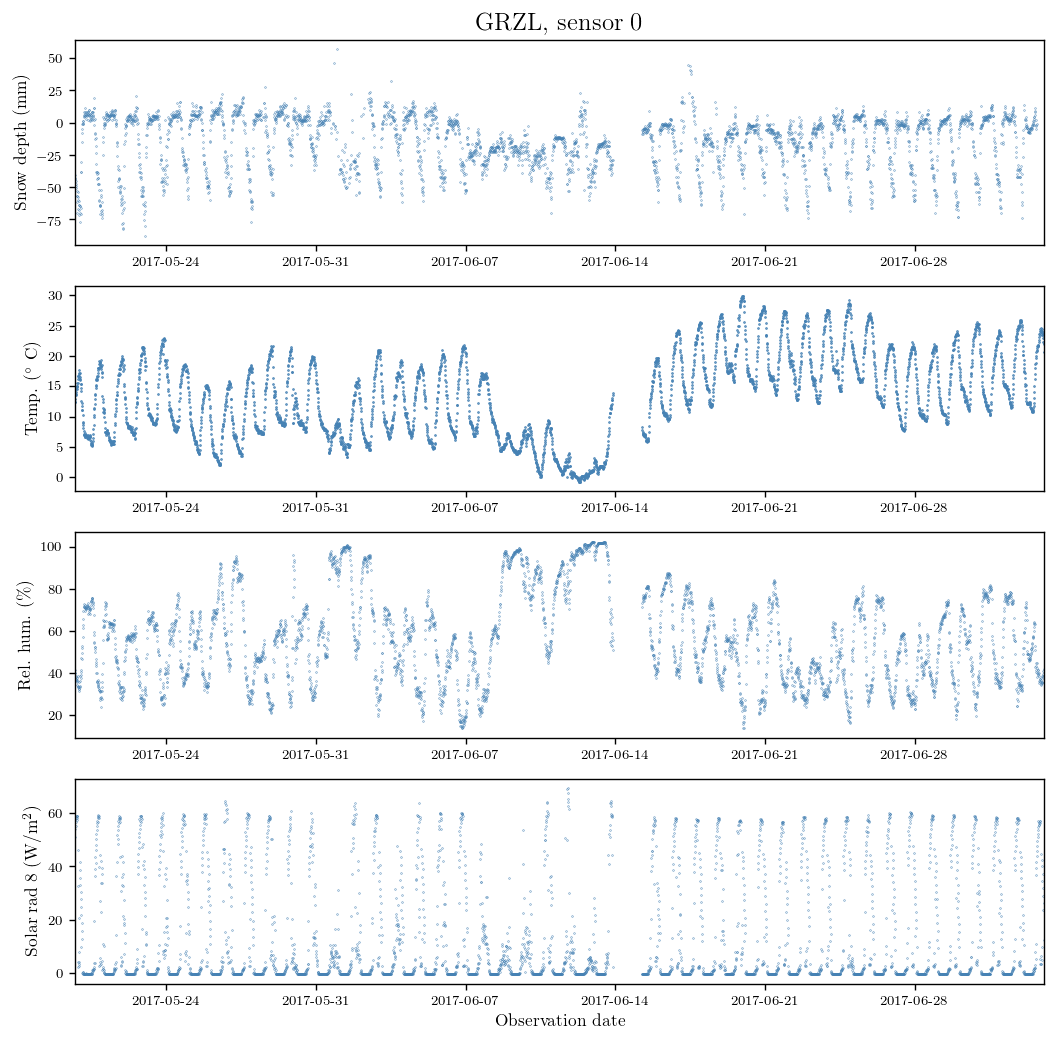

In [226]:
plt.figure(figsize=(10, 10))

sensor = 0

# Choose time range to plot
i_ti = 26500
i_tf = 30850
times = df_wsn["time"].values[i_ti:i_tf]

# Extract data
snowdepths = df_wsn["snowdepth_%i" % sensor].values[i_ti:i_tf]
snowdepth_stdevs = df_wsn["snowdepth_stdev_%i" % sensor].values[i_ti:i_tf]
rel_humidity = df_wsn["rel_humidity_%i" % sensor].values[i_ti:i_tf]
air_temp = df_wsn["air_temp_%i" % sensor].values[i_ti:i_tf]

# Use single sensor's solar radiation as proxy for site
wsn_solar_rad = df_wsn["solar_rad_8"].values[i_ti:i_tf]

### Plot the data

plt.subplot(4, 1, 1)
plt.title(wsn + ", sensor %i" % sensor)
plt.plot(times, snowdepths, '.', markersize=0.5, color="steelblue")
#for t, sd, sd_stdev in zip(times, snowdepths, snowdepth_stdevs):
#    plt.plot(2*[t], [sd-sd_stdev, sd+sd_stdev], '-', linewidth=0.5, color="steelblue")
plt.ylabel("Snow depth (mm)")
plt.xlim(min(times), max(times))

print "Plotted snow depth"

plt.subplot(4, 1, 2)
plt.plot(times, air_temp, '.', markersize=1)
plt.ylabel(r"Temp. ($^\circ$ C)")
plt.xlim(min(times), max(times))

print "Plotted air temp"

plt.subplot(4, 1, 3)
plt.plot(times, rel_humidity, '.', markersize=0.5)
plt.ylabel("Rel. hum. (\%)")
plt.xlim(min(times), max(times))

print "Plotted rel humidity"

plt.subplot(4, 1, 4)
plt.plot(times, wsn_solar_rad, '.', markersize=0.5)
plt.xlabel("Observation date")
plt.ylabel(r"Solar rad 8 (W/m$^2$)")
plt.xlim(min(times), max(times))

print "Plotted solar radiation"